# LDA和QDA

## 线性判别分析（LDA）

LDA的全称是Linear Discriminant Analysis（线性判别分析），是一种supervised learning。有些资料上也称为是Fisher’s Linear Discriminant，因为它被Ronald Fisher发明自1936年。


LDA的思想是[1]：最大化类间均值，最小化类内方差。意思就是将数据投影在低维度上，并且投影后同种类别数据的投影点尽可能的接近，不同类别数据的投影点的中心点尽可能的远。

假设我们有两类数据 分别为红色和蓝色，如下图所示，这些数据特征是二维的，我们希望将这些数据投影到一维的一条直线，让每一种类别数据的投影点尽可能的接近，而红色和蓝色数据中心之间的距离尽可能的大。从图中可以看出，右图的投影方式将红色和蓝色全部区分开了。
![](../../images/lda.png)

LDA的数学公式：

LDA首先是为了分类服务的，因此只要找到一个投影方向ω，使得投影后的样本尽可能按照原始类别分开。

逻辑上我们可能得实现思路是：
1. 先找到类的中心，来代表一个类的核心特征
2. 再计算类内样本的差异性，尽可能小
3. 然后计算类间样本的差异性，尽可能大
4. 最后，求目标函数得到投影向量

那么，换成数学表达就是：
1. 均值向量：对于每个类别 $i$，计算该类别所有样本特征向量的平均值。这个平均值被称为类别内均值向量 $\mu_i$。

公式：$\mu_i = \frac{1}{N_i} \sum_{x \in i} x$，其中 $x$ 属于类别 $i$，$N_i$ 是类别 $i$ 的样本数量。
 

2. 协方差矩阵：对于每个类别 $i$，计算该类别内样本与其类别内均值向量之间的协方差矩阵。协方差矩阵衡量了同一类别内样本之间的差异程度。

公式：$S_i = \frac{1}{N_i - C} \sum_{x \in i}(x - \mu_i)(x - \mu_i)^T$，其中 $C$ 是类别数量。


3. 散度矩阵：计算不同类别之间的差异程度。通过计算每个类别均值向量 $\mu_i$ 与总体均值向量 $\mu$ 之间的协方差矩阵，可以得到类间散度矩阵 $S_b$。

公式：$S_b = \frac{1}{C-1} \sum_{i=1}^{C} N_i (\mu_i - \mu)(\mu_i - \mu)^T$，其中 $\mu$ 是总体均值向量。

4. 解广义特征值：LDA的目标是找到一个投影向量 $w$，使得投影后的数据能够最大化同类样本之间的差异并最小化不同类样本之间的差异。
这可以通过求解广义特征值问题来实现。

广义特征值问题的目标函数为：$J(w) = \frac{w^T S_b w}{w^T S_w w}$，
其中 $S_b$ 是类间散度矩阵，$S_w$ 是类别内散度矩阵。

通过求解这个特征值问题，我们可以得到最佳的投影向量 $w$，用于将高维数据映射到低维空间，并实现优秀的分类效果。

/var/folders/8j/27zsmq_50nz33kg5qj17nxqh0000gn/T/ipykernel_24915/3074259613.py:16: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.cm.register_cmap(cmap=cmap)


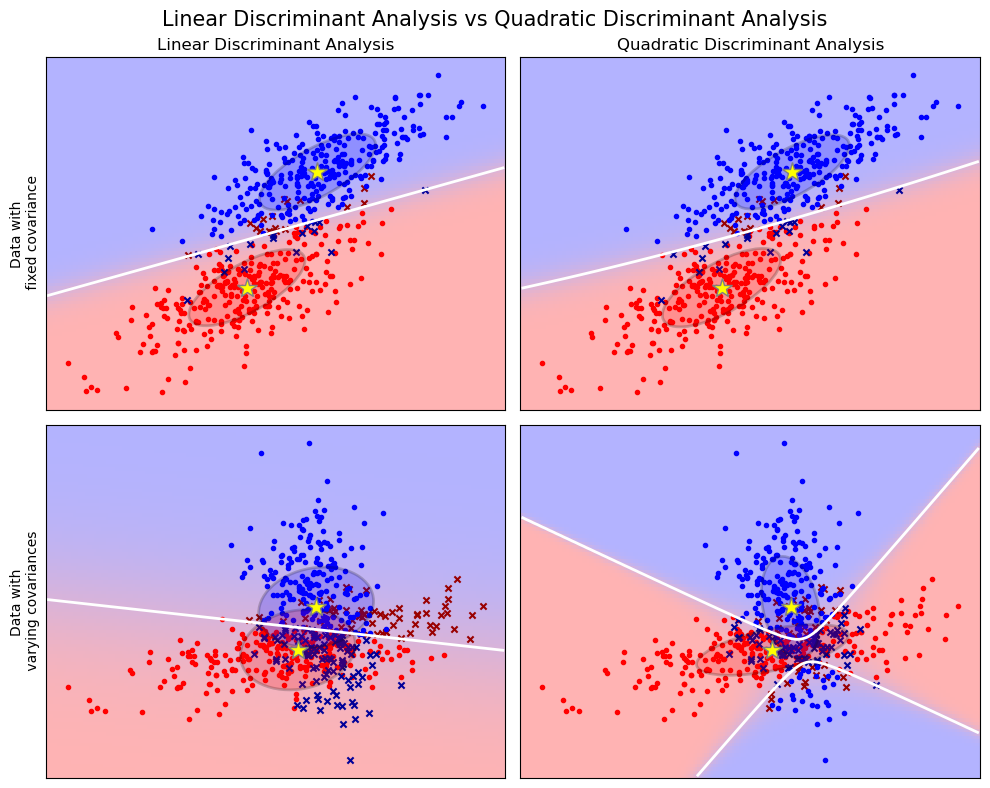

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from scipy import linalg

# 颜色
cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)

# 数据
def dataset_fixed_cov():
    """Generate 2 Gaussians samples with the same covariance matrix"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -0.23], [0.83, 0.23]])
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C) + np.array([1, 1]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    """Generate 2 Gaussians samples with different covariance matrices"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -1.0], [2.5, 0.7]]) * 2.0
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


# 可视化
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
        plt.ylabel("Data with\n fixed covariance")
    elif fig_index == 2:
        plt.title("Quadratic Discriminant Analysis")
    elif fig_index == 3:
        plt.ylabel("Data with\n varying covariances")

    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        angle=180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")
    
plt.figure(figsize=(10, 8), facecolor="white")
plt.suptitle(
    "Linear Discriminant Analysis vs Quadratic Discriminant Analysis",
    y=0.98,
    fontsize=15,
)

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis("tight")

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis("tight")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

线性判别分析和二次判别分析是两个经典的分类器。它们可以很容易计算得到闭式解（即解析解）。

以上这些图像展示了线性判别分析以及二次判别分析的决策边界。其中，最后一行表明了线性判别分析只能学习线性边界， 而二次判别分析则可以学习二次边界

## 参考

* [1] 线性判别分析LDA原理总结 https://www.cnblogs.com/pinard/p/6244265.html
* [2] 线性判别分析(LDA)详解 https://blog.csdn.net/weixin_55073640/article/details/124763816
